# Data processing

In [569]:
#|code-fold: true
#|output: false
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import matplotlib.ticker as ticker

import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import platform
from PIL import Image
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

from step_by_step import StepByStep, InverseNormalize
from models import Segnet
plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We have accumulated labels in the `data\all_labels` folder. We need to:
- load all of them into NCWH tensors
- split them into train and valid (test labels will be separate), 
- create temporary Datasets and normalizer
- create real Datasets and DataLoaders. 

## Generate tensors

Let's first create a `x_tensor/y_tensor` from all_labels:

In [570]:
proj_dir = Path('.').resolve().parent
data_dir = proj_dir / 'data'
train_imgs_dir = data_dir / 'all_labels/train/imgs'
train_masks_dir = data_dir / 'all_labels/train/masks'
image_paths = sorted(list(train_imgs_dir.glob('*.png')))
mask_paths = sorted(list(train_masks_dir.glob('*.png')))

In [571]:
len(image_paths)

238

Check there are no missing files:


In [572]:
a = set([x.name for x in image_paths])
b = set([x.name for x in mask_paths])
assert len(a ^ b) == 0

to go from a `Path` to `Tensor` use `torchvision.transforms.ToTensor()`:

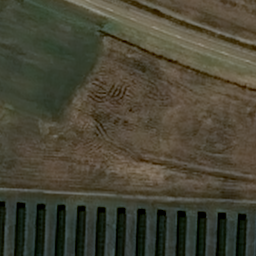

In [573]:
im = Image.open(image_paths[100])
im

In [574]:
image_tensor = ToTensor()(im)
image_tensor.shape

torch.Size([3, 256, 256])

For the mask, we'll use multi-class labeling, class 0 will be background, class 1 will be solar pannels (and later we'll have class 2 for posts etc). For start we convert the png mask to grayscale via `'L'`:

In [575]:
mask = Image.open(mask_paths[100])
mask_tensor = torch.squeeze(ToTensor()(mask.convert('L')))  # reduces from 'RGBA' bands to 'L' band (i.e. grayscale) and drops zero-length dimension

In [576]:
mask_tensor = (mask_tensor > 0).float()  # creates a binary mask
mask_tensor.shape

torch.Size([256, 256])

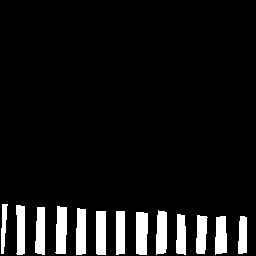

In [577]:
ToPILImage()(mask_tensor)

In [578]:
mask_tensor.unique()

tensor([0., 1.])

Let's combine these conversions:

In [579]:
tensorizer = ToTensor()

n_channels, h, w = ToTensor()(Image.open(image_paths[0]).convert('RGB')).shape

x_tensor = torch.zeros([len(image_paths), n_channels, h, w])
y_tensor = torch.zeros([len(image_paths), h, w], dtype=torch.long)  # we'll have only class number mask

for i, (image_path, mask_path) in enumerate(zip(tqdm(image_paths), mask_paths)):
    x_tensor[i,:,:,:] = ToTensor()(Image.open(image_path).convert('RGB'))
    
    mask = Image.open(mask_path)
    mask_tensor = torch.squeeze(ToTensor()(mask.convert('L')))  # reduces from 'RGBA' bands to 'L' band
    mask_tensor = (mask_tensor > mask_tensor.min()).long() # creates a binary mask, converts to integers
    mask_tensor.masked_fill_(x_tensor[i,2,:,:] == 0, -1)  # labels-out-of-scope regions as -1, these will be removed later
    y_tensor[i,:,:] = mask_tensor  
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:01<00:00, 140.19it/s]


In [580]:
print(x_tensor.shape)
print(y_tensor.shape)

torch.Size([238, 3, 256, 256])
torch.Size([238, 256, 256])


## Split into train and valid

We'll use `torch.utils.data.random_split`:

In [581]:
torch.manual_seed(13)  # Important for consistency
N = len(x_tensor)
n_train = int(.8*N)
n_val = N - n_train
train_subset, val_subset = random_split(x_tensor, [n_train, n_val])

train_idx = train_subset.indices
val_idx = val_subset.indices

print(train_idx)
print(val_idx)

[178, 41, 216, 99, 142, 214, 58, 108, 72, 129, 125, 98, 134, 94, 48, 226, 158, 206, 163, 175, 9, 144, 114, 231, 52, 182, 107, 54, 139, 183, 18, 32, 191, 162, 5, 149, 95, 14, 122, 132, 21, 212, 118, 11, 35, 192, 179, 194, 101, 173, 126, 172, 26, 33, 85, 205, 69, 70, 185, 202, 222, 124, 200, 234, 55, 92, 77, 22, 146, 161, 73, 13, 44, 180, 90, 112, 91, 8, 24, 20, 50, 154, 93, 51, 110, 219, 66, 97, 235, 197, 80, 130, 230, 117, 106, 168, 65, 76, 88, 68, 169, 184, 215, 60, 121, 16, 2, 207, 165, 96, 136, 64, 225, 45, 47, 187, 140, 193, 153, 46, 61, 1, 189, 164, 190, 87, 53, 155, 199, 210, 63, 15, 57, 224, 115, 170, 29, 25, 233, 111, 232, 7, 171, 213, 128, 34, 79, 37, 131, 74, 151, 116, 36, 181, 10, 119, 177, 59, 78, 75, 211, 100, 166, 83, 19, 228, 49, 23, 105, 159, 82, 42, 135, 237, 43, 227, 221, 120, 133, 103, 156, 102, 3, 123, 27, 104, 17, 148, 30, 12]
[89, 143, 157, 201, 203, 150, 152, 62, 176, 217, 127, 167, 141, 137, 56, 196, 28, 31, 71, 145, 220, 6, 229, 147, 186, 113, 195, 81, 218, 198

In [582]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

In [583]:
print(x_train_tensor.shape)
print(y_train_tensor.shape)
print(x_val_tensor.shape)
print(y_val_tensor.shape)

torch.Size([190, 3, 256, 256])
torch.Size([190, 256, 256])
torch.Size([48, 3, 256, 256])
torch.Size([48, 256, 256])


In [584]:
print(x_train_tensor.dtype)
print(y_train_tensor.dtype)
print(x_val_tensor.dtype)
print(y_val_tensor.dtype)

torch.float32
torch.int64
torch.float32
torch.int64


Since this is unbalanced dataset, we find contributions for each class:

In [585]:
print((y_train_tensor == -1).float().sum() / np.prod(y_train_tensor.shape))
print((y_train_tensor == 0).float().sum() / np.prod(y_train_tensor.shape))
print((y_train_tensor == 1).float().sum() / np.prod(y_train_tensor.shape))

tensor(0.0283)
tensor(0.6885)
tensor(0.2832)


In [586]:
weights = torch.Tensor([0.28, 0.69])
weights

tensor([0.2800, 0.6900])

## Temporary Datasets

Our very simple dataset with transform:

In [587]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

Let's first create **temporary** `Dataset` to extract normalization parameters:

In [588]:
temp_train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor)
temp_train_loader = DataLoader(temp_train_dataset, batch_size=32)
normalizer = StepByStep.make_normalizer(temp_train_loader)
normalizer

Normalize(mean=tensor([0.2069, 0.2199, 0.1740]), std=tensor([0.1057, 0.1047, 0.1052]))

## Real Datasets and Loaders

Let's now create **real** `Datasets` and `DataLoaders`:

In [589]:
train_composer = Compose([normalizer])  # train_composer will have augmentations later
val_composer = Compose([normalizer])

train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Training prep

Let's now define model, optimizer, and loss.

## Model

In [590]:
segnet = Segnet(n_channels=3, n_classes=2)
x, y = next(iter(train_loader))
segnet.eval()  # sets the mode
yhat = segnet(x)
yhat.shape

torch.Size([32, 2, 256, 256])

Cool, it checks out, we got two classes out.  

For predictions, we can use two methods:
- we can apply `Softmax` to logits that simply forces values to be in range [0,1] then set the threshold of 0.5:
- simply get the `argmax` accross class dimension (axis=1)

Using `Softmax` method:

In [591]:
predictions_softmax = nn.Softmax(dim=1)(yhat)
predictions_softmax.shape

torch.Size([32, 2, 256, 256])

let's plot 0th image as an example (we have to convert Tensor to PIL Image):

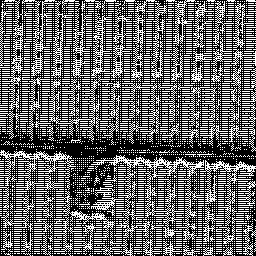

In [592]:
a = (predictions_softmax[0, 1, :, :] > 0.5).float()
ToPILImage()(a)

or using `argmax` method:

In [593]:
predictions_argmax = yhat.argmax(1)  # accross all classes, i.e. 1st dimension

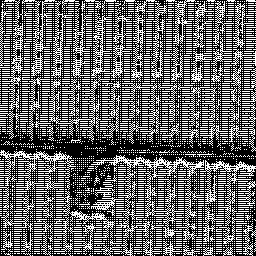

In [594]:
b = predictions_argmax[0,:,:].float()  # convert Tensor to PIL
ToPILImage()(b)

In [595]:
assert torch.all(a == b)

proving that results are the same.

While the predictions are not great after one epoch only, we are starting to notice the shape of the solar panels already.

## Visualization

The original image looks like:

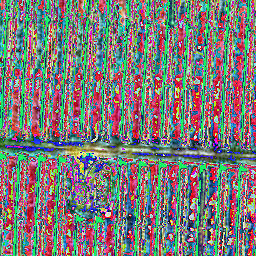

In [596]:
ToPILImage()(x[0,:,:,:])

and this looks weird since image was already normalized. Just for ploting, we can unnormalize it:

In [597]:
inv_normalizer = InverseNormalize(normalizer)

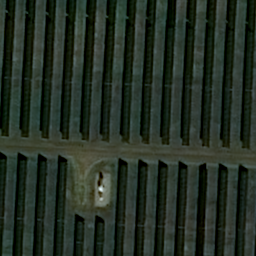

In [598]:
ToPILImage()(inv_normalizer(x[0,:,:,:]))

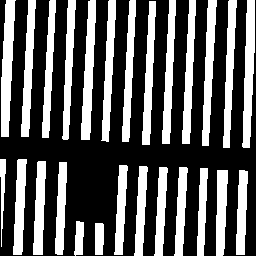

In [599]:
ToPILImage()(y[0,:,:].float())

## Optimizer and Loss

Let's define optimizer:

In [600]:
optimizer = optim.Adam(segnet.parameters(), lr=3e-4)

Let's do the mock loss evaluation:

In [601]:
def multi_loss_fn(y_pred, y_true):
    # return nn.CrossEntropyLoss()(y_pred, y_true)
    out_of_bounds = (y_true == -1) # find out the out-of-bounds
    # replace out-of-bounds pixels with zeros
    return nn.CrossEntropyLoss()(y_pred.masked_fill(out_of_bounds.unsqueeze(axis=1), 0), 
                                 y_true.masked_fill(out_of_bounds, 0))

In [602]:
torch.manual_seed(17)
sbs = StepByStep(segnet, optimizer, multi_loss_fn)
sbs.set_loaders(train_loader, val_loader)

# Training

In [625]:
sbs.train(7)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:16<00:00, 36.61s/it]


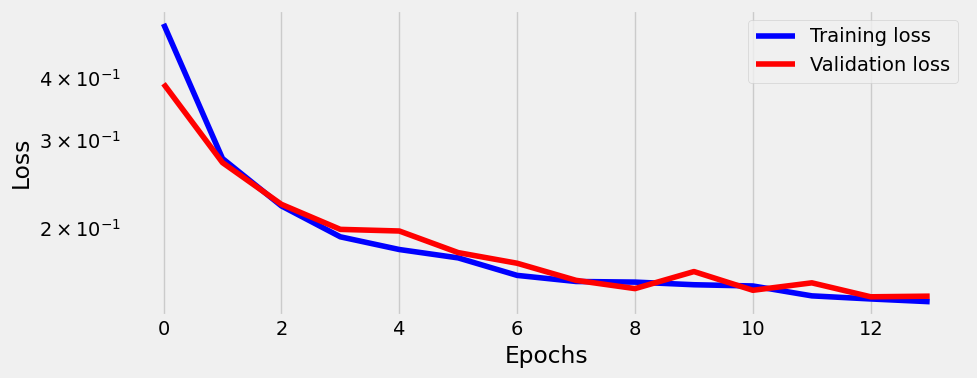

In [626]:
_ = sbs.plot_losses()

Let's visualize some of the predictions for `val_loader`:

In [627]:
val_loader_iter = iter(val_loader)

In [663]:
x_val, y_val = next(val_loader_iter)

StopIteration: 

In [657]:
def display_images(x_batch, y_batch, show_original=False, normalizer=None, idx_map=None, idx_offset=0):
    if show_original:
        inv_normalizer = InverseNormalize(normalizer)
    
    if len(x_batch) > 64:
        raise Warning(f"There are {len(x_batch)} images to show, I set the limit to 64.")
        return
    
    y_pred_batch = sbs.predict(x_batch, to_numpy=False)
    out_of_bounds = y_batch == -1
    y_pred_batch.masked_fill_(out_of_bounds.unsqueeze(1), 0).detach().cpu().numpy()

    for idx in range(len(x_batch)):
        # convert to PIL images

        img_a = Image.fromarray(np.uint8(y_pred_batch.argmax(1)[idx,:,:]*255))
        img_b = ToPILImage()(y_batch[idx,:,:].float())
        if show_original:
            img_c = ToPILImage()(inv_normalizer(x_batch[idx,:,:,:]))
        
        N = 3 if show_original else 2
        fig, ax = plt.subplots(1,N)
        ax[0].imshow(img_a)
        ax[0].set_title(f"{idx_offset + idx} - {'' if not idx_map else idx_map[idx_offset + idx]}")
        ax[1].imshow(img_b)
        if show_original: 
            ax[2].imshow(img_c)
        for i in range(N):
            ax[i].grid(False)
            ax[i].xaxis.set_major_locator(ticker.NullLocator())
            ax[i].yaxis.set_major_locator(ticker.NullLocator())
        plt.show()

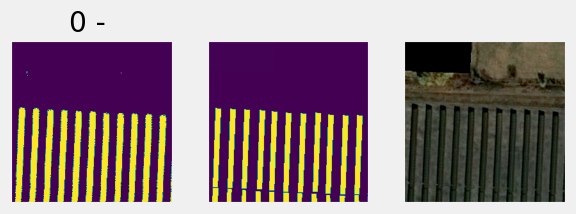

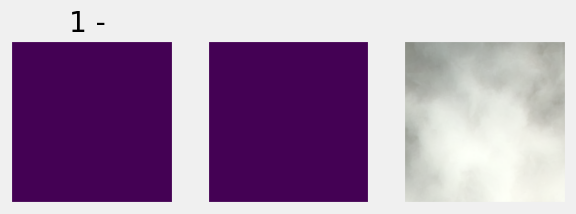

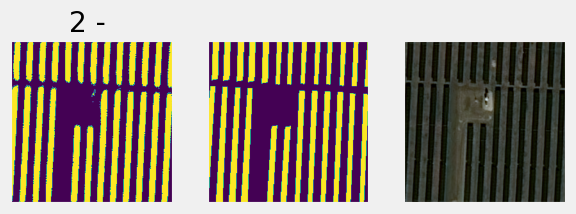

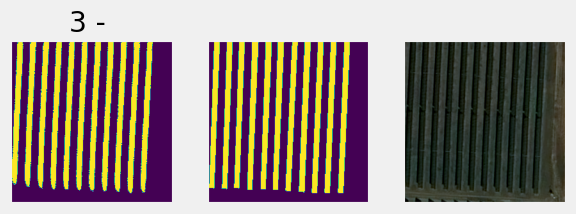

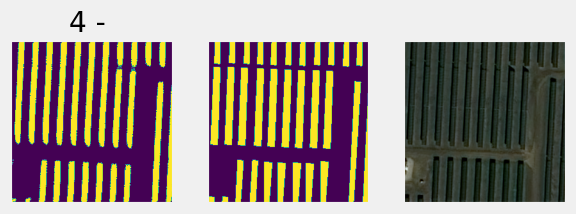

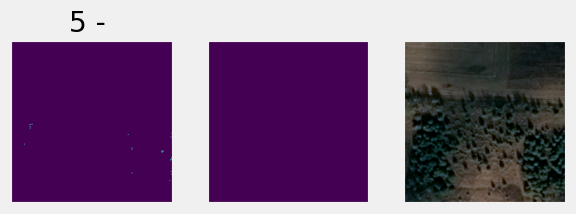

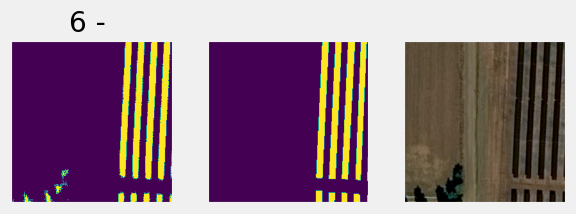

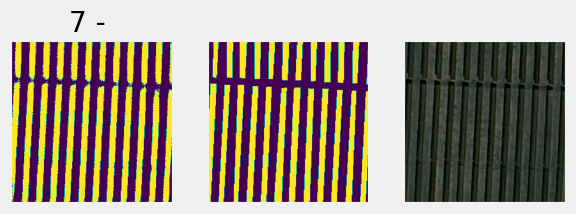

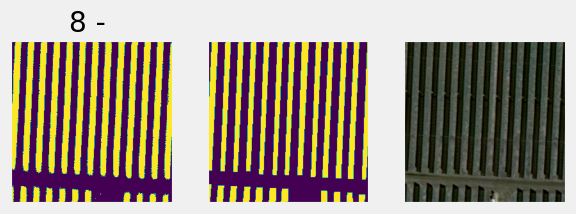

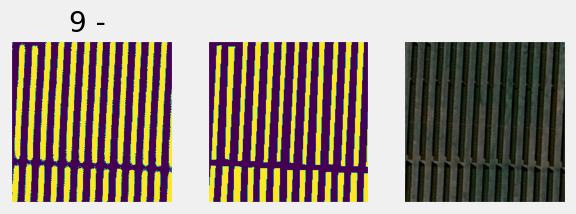

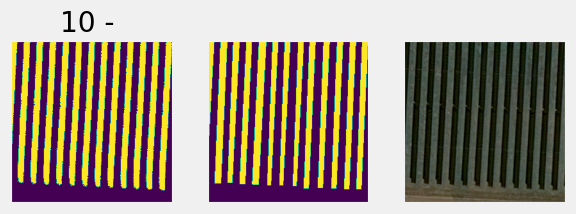

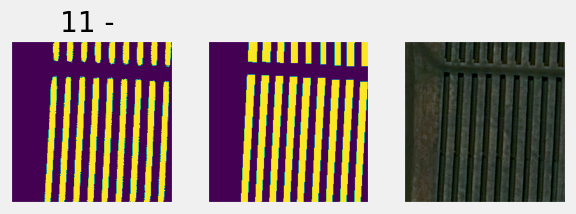

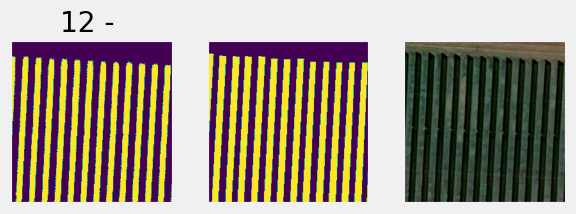

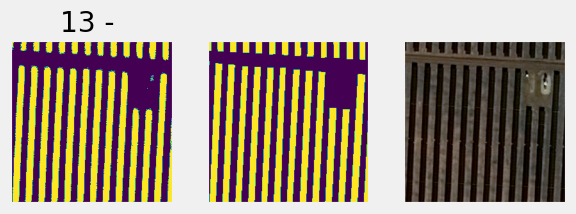

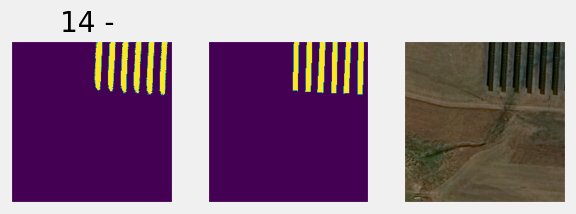

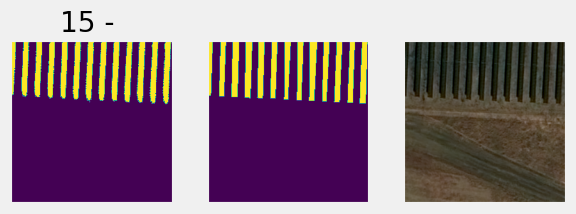

In [664]:
display_images(x_val, y_val, True, normalizer)

This is a very good start. 

Let's save the model:

In [631]:
# sbs.save_checkpoint('2022_01_04_segnet.tar')

to load the model reinitialize the sbs (with model, optimizer, and loss), then run:

In [632]:
# sbs.load_checkpoint('2022_01_04_segnet.tar')

# Evaluation

## Evaluation dataset

Let's evaluate the model on unseen images. First we'll generate an `x_eval_tensor`:

In [669]:
eval_imgs_dir = data_dir / '6126758101/IMG_PHR1B_PMS-N_001/cropped'
eval_image_paths = sorted(list(eval_imgs_dir.glob('*.png')))

In [670]:
len(eval_image_paths)

6529

In [676]:
tensorizer = ToTensor()
n_channels, h, w = ToTensor()(Image.open(eval_image_paths[0]).convert('RGB')).shape

x_eval_tensor = torch.zeros([len(eval_image_paths), n_channels, h, w])
y_eval_tensor = torch.zeros([len(eval_image_paths), h, w], dtype=torch.long)  # we'll have only class number mask
idx_map = {}

for i, image_path in enumerate(tqdm(eval_image_paths)):
    x_eval_tensor[i, :, :, :] = ToTensor()(Image.open(image_path))
    
    mask_tensor = torch.zeros(*x_eval_tensor.shape[2:])
    mask_tensor.masked_fill_(x_eval_tensor[i,2,:,:] == 0, -1)  # labels-out-of-scope regions as -1, these will be removed later
    y_eval_tensor[i,:,:] = mask_tensor
    
    idx_map[i] = image_path.name

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6529/6529 [00:29<00:00, 220.30it/s]


In [677]:
x_eval_tensor_size = x_eval_tensor.element_size() * x_eval_tensor.nelement() / (10**9)

The `x_eval_tensor` is {{x_eval_tensor_size}} Gb.

Next we create a dataset, we'll reuse `val_composer` since it contains only normalization:

In [678]:
eval_dataset = TransformedTensorDataset(x_eval_tensor, y_eval_tensor, transform=val_composer)
batch_size = 32
eval_loader = DataLoader(eval_dataset, batch_size=batch_size)
eval_loader_iter = iter(eval_loader)
batch_idx = -1

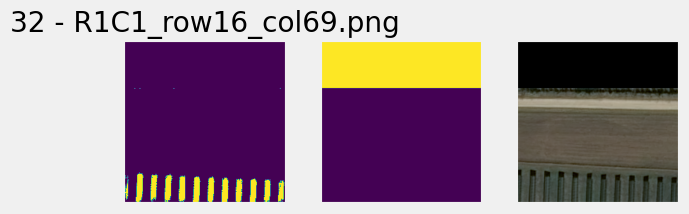

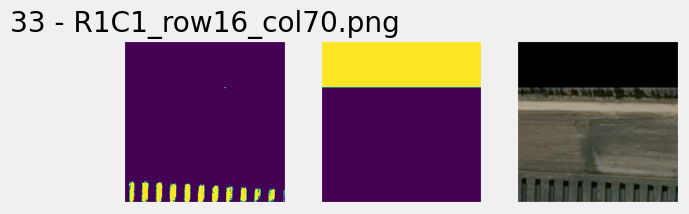

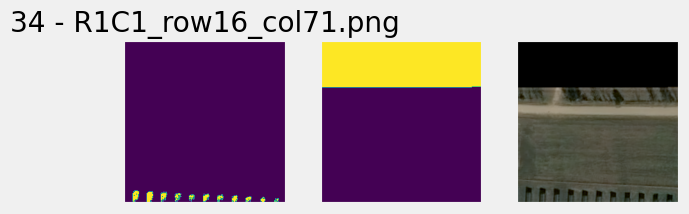

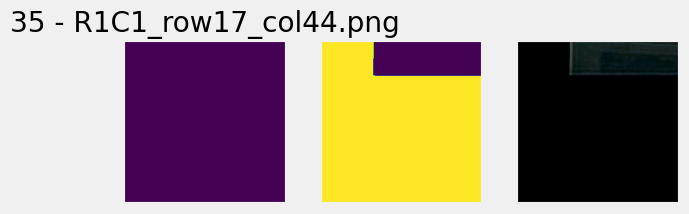

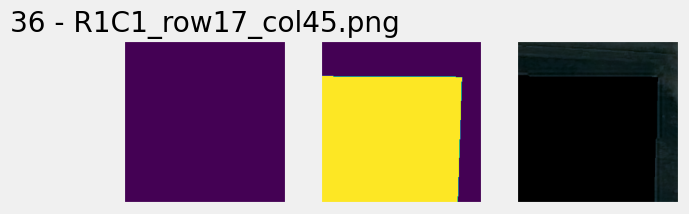

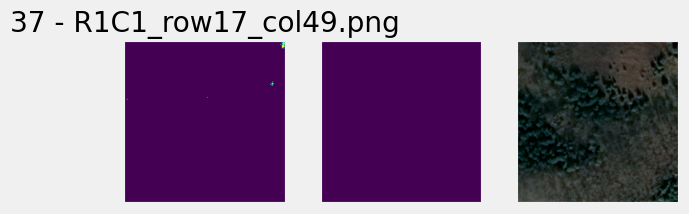

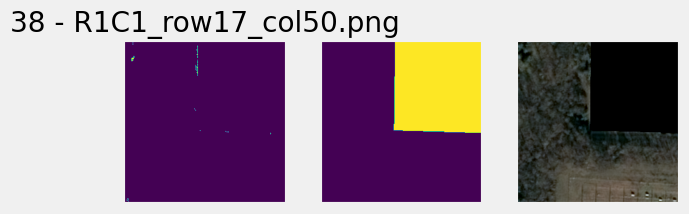

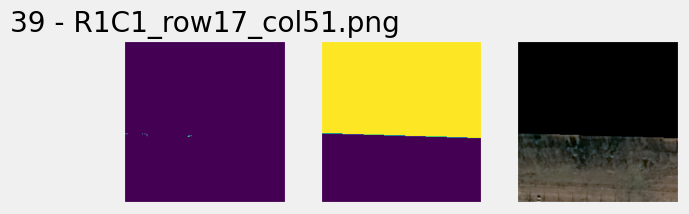

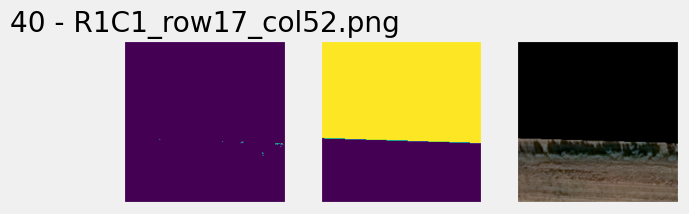

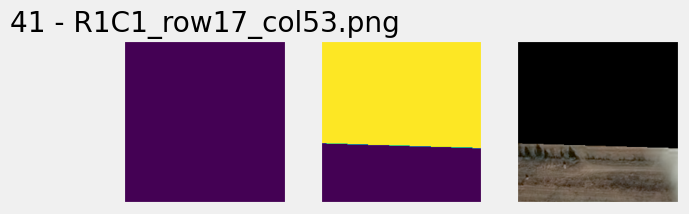

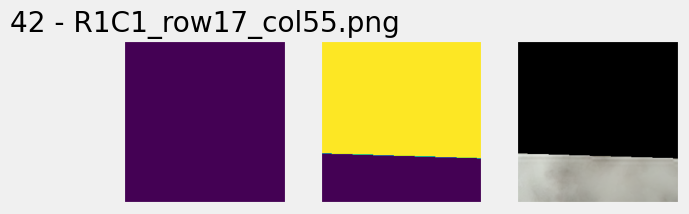

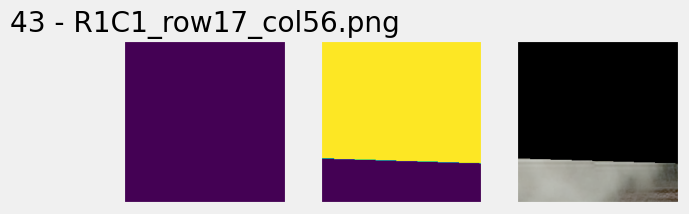

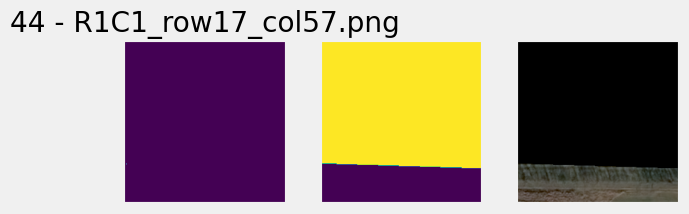

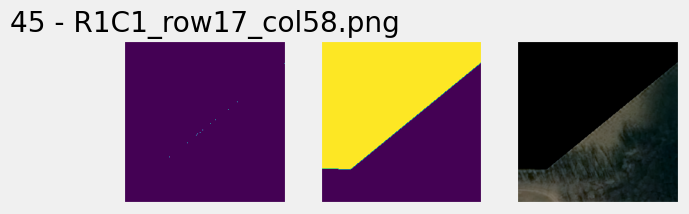

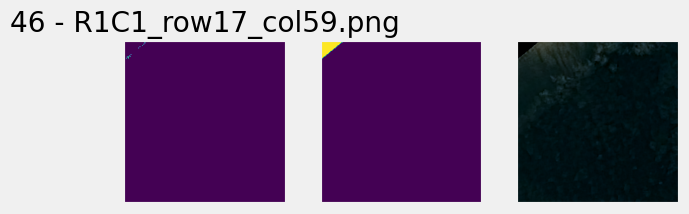

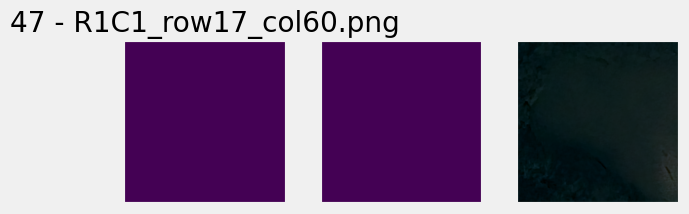

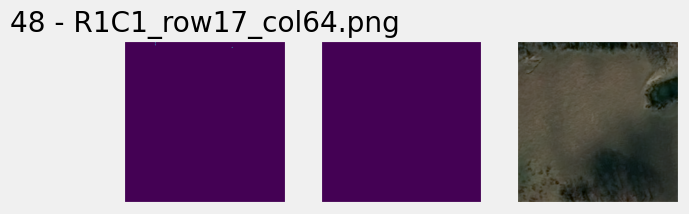

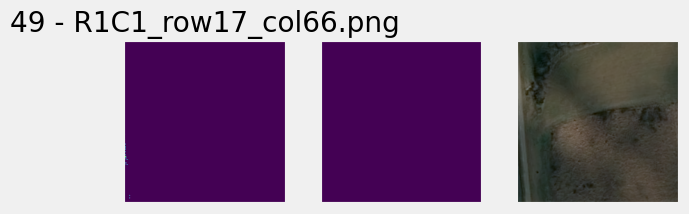

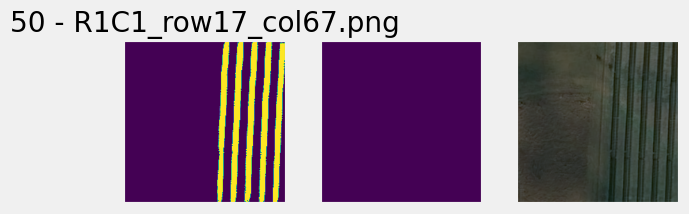

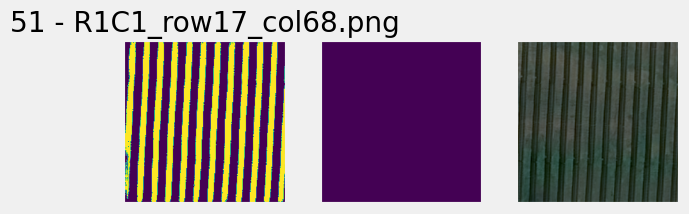

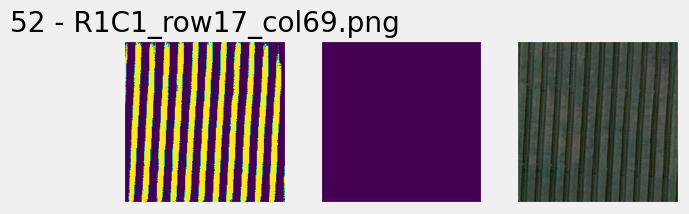

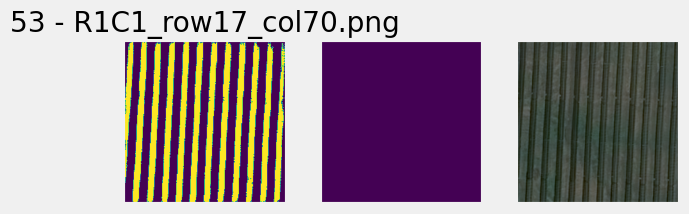

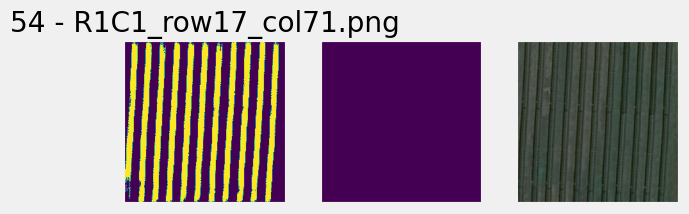

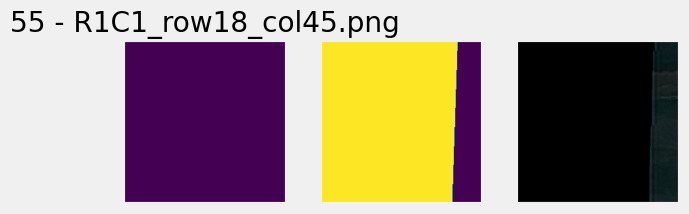

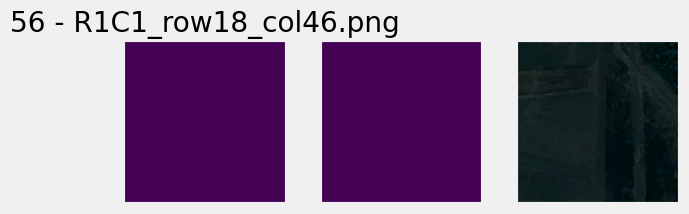

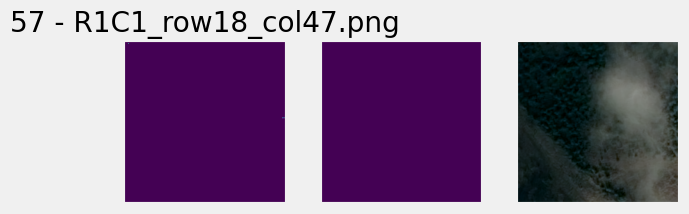

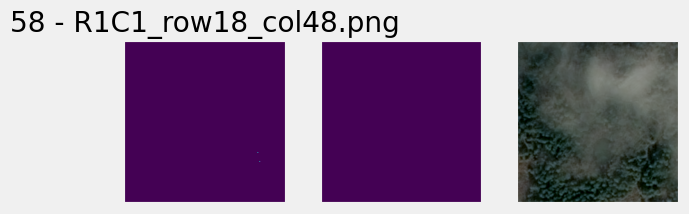

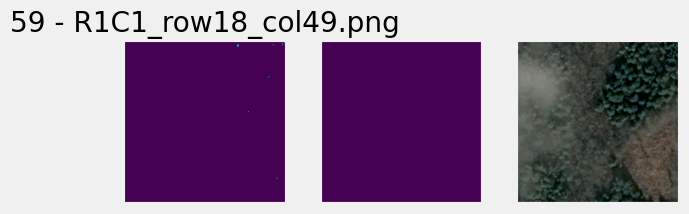

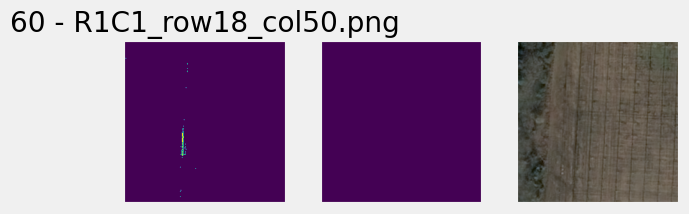

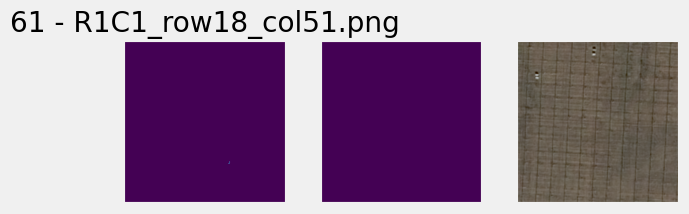

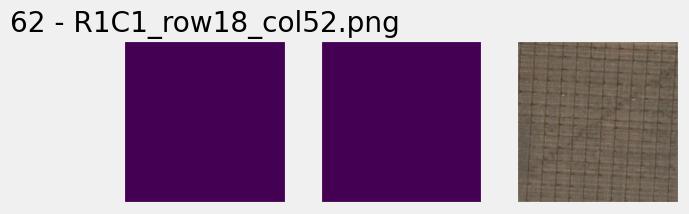

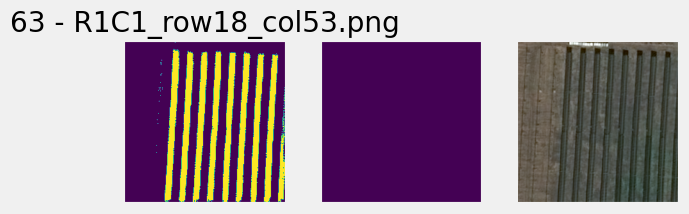

In [680]:
(x_eval, y_eval), batch_idx = next(eval_loader_iter), batch_idx + 1 
display_images(x_eval, y_eval, True, normalizer, idx_map, batch_idx*batch_size)

So clearly some of the solar panels are detected, but now nearly as good as in validation set. This means our training and validation sets are not representing the whole eval set. Furthermore, there are lot's of false positives. We need to do the following:
- augmentation
- adding more solar-panel images to the training dataset
- adding non-solar-panels images to the training dataset.

## mean/stdev plots

To see the range of mean and stdev accross `train` and `eval` datasets, let's look into mean and stdev for **individial** images, i.e. mean and stdev accross channels for all training and eval images **before** normalization. A straightforward way to do this is by using `x_train_tensor` and `x_eval_tensor`:

In [683]:
def get_means_and_stdevs(some_tensor):
    some_tensor = some_tensor.flatten(2,3)
    means = some_tensor.mean(axis=2)
    stdevs = some_tensor.std(axis=2)
    return means, stdevs

def plot_means_and_stdevs(train_means, train_stdevs, eval_means, eval_stdevs):
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    for i in range(3):
        axs[i].plot(eval_means[:,i], eval_stdevs[:,i], '.')
        axs[i].plot(train_means[:,i], train_stdevs[:,i], '.')
        axs[i].set_xlabel('means')
        axs[i].set_ylabel('stdev')
        axs[i].set_title(f'Channel #{i+1}')
        axs[i].legend(['eval', 'train'])
    plt.show()

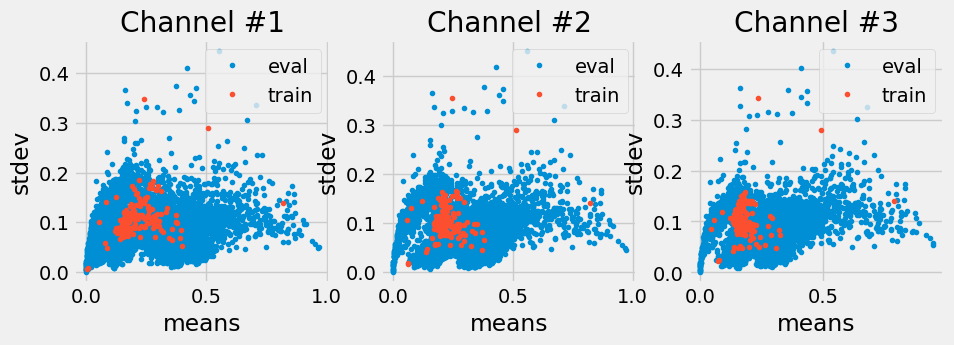

In [684]:
train_means, train_stdevs = get_means_and_stdevs(x_train_tensor)
eval_means, eval_stdevs = get_means_and_stdevs(x_eval_tensor)
plot_means_and_stdevs(train_means, train_stdevs, eval_means, eval_stdevs)

So we see that train dataset is not covering all the cases, far from it. 

Let's now plot a similar versions using `normalizer`:

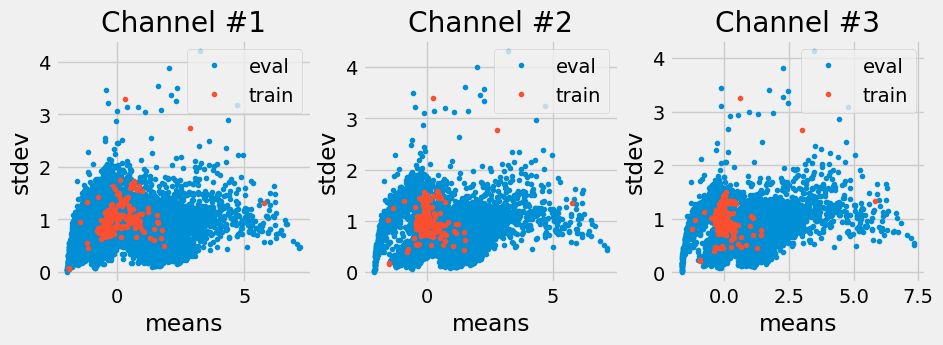

In [685]:
train_means, train_stdevs = get_means_and_stdevs(normalizer(x_train_tensor))
eval_means, eval_stdevs = get_means_and_stdevs(normalizer(x_eval_tensor))
plot_means_and_stdevs(train_means, train_stdevs, eval_means, eval_stdevs)

and we see that `train` dataset has mean/stdev at 0/1, but that's not nearly the case for `eval` dataset.

## Add non-solar-panel training images

Let's create a background mask:

In [682]:
from categorize import LABELS, load_paths, check_for_missing_files

In [101]:
background_mask = Image.fromarray(np.zeros([256, 256], dtype=np.uint8))

In [103]:
label_type = 'background'
background_mask.save(LABELS / label_type / 'masks/background.png')

get all the names from `imgs` folder:

In [116]:
image_paths, mask_paths = load_paths(label_type)
check_for_missing_files(image_paths, mask_paths)

In [115]:
import shutil
dst_folder = LABELS / label_type / 'masks'
for image_path in image_paths:
    shutil.copy(dst_folder / 'background.png', dst_folder / image_path.name)

## Dice coeficient


Dice coefficient quantifies our model ...

## Augmentation

Let's create a new composer ...